In [198]:
library(ggplot2)
library(dplyr) #getMap()
library(rgeos)
#install.packages('rworldmap')
library(rworldmap) #joinCountryData2Map
library(grid)
library(tidyr)
#install.packages(c("cowplot", "googleway", "ggplot2", "ggrepel", "ggspatial", "sf", "rnaturalearth", "rnaturalearthdata"))
library("sf")
library("rnaturalearth")
library("rnaturalearthdata")

In [236]:
df = read.csv('../../results/dfcluster.csv') #change name of file to sth descriptive (e.g. country-clusters)

In [237]:
df = df[,c(2,33)] # select only country name and cluster number

In [238]:
colnames(df) = c('region', 'value') # change column names for ggplot
dim(df)
head(df)

[1] 78  2

,region,value
,<chr>,<int>
1,Afghanistan,1
2,Albania,2
3,Angola,3
4,Armenia,2
5,Azerbaijan,4
6,Bangladesh,1


In [239]:
# This is to convert country names in df to match those in the worldMap dataframe
coords <- joinCountryData2Map(df, joinCode = "NAME", nameJoinColumn = "region")
coords = data.frame(coords)
colnames(coords) = tolower(colnames(coords))
colnames(coords)
coords = drop_na(coords, value)
coords$name

76 codes from your data successfully matched countries in the map
2 codes from your data failed to match with a country code in the map
167 codes from the map weren't represented in your data


[1] "scalerank"    "labelrank"    "featurecla"   "sovereignt"   "sov_a3"      
 [6] "adm0_dif"     "level"        "type"         "admin"        "adm0_a3"     
[11] "geou_dif"     "geounit"      "gu_a3"        "su_dif"       "subunit"     
[16] "su_a3"        "name"         "abbrev"       "postal"       "name_forma"  
[21] "terr_"        "name_sort"    "map_color"    "pop_est"      "gdp_md_est"  
[26] "fips_10_"     "iso_a2"       "iso_a3"       "iso_n3"       "iso3"        
[31] "lon"          "lat"          "iso3.1"       "admin.1"      "region"      
[36] "continent"    "geo3major"    "geo3"         "image24"      "glocaf"      
[41] "stern"        "sresmajor"    "sres"         "gbd"          "avoidnumeric"
[46] "avoidname"    "ldc"          "sid"          "lldc"         "region"      
[51] "value"        "admin.2"      "iso3.2"

[1] Afghanistan           Angola                Albania              
 [4] Armenia               Azerbaijan            Burundi              
 [7] Benin                 Burkina Faso          Bangladesh           
[10] Bolivia               Brazil                Central African Rep. 
[13] Ivory Coast           Cameroon              Congo (Brazzaville)  
[16] Colombia              Dominican Rep.        Egypt                
[19] Eritrea               Ethiopia              Gabon                
[22] Ghana                 Guinea                Gambia               
[25] Guatemala             Guyana                Honduras             
[28] Haiti                 Indonesia             India                
[31] Jordan                Kazakhstan            Kenya                
[34] Kyrgyzstan            Cambodia              Liberia              
[37] Lesotho               Morocco               Moldova              
[40] Madagascar            Mali                  Myanmar              
[43] Mozambique            Mauritania            Malawi               
[46] Namibia               Niger                 Nigeria              
[49] Nicaragua             Nepal                 Pakistan             
[52] Peru                  Philippines           Papua New Guinea     
[55] Paraguay              Rwanda                Senegal              
[58] Sierra Leone          Chad                  Togo                 
[61] Tajikistan            Turkmenistan          East Timor           
[64] Turkey                Tanzania              Uganda               
[67] Ukraine               Uzbekistan            Vietnam              
[70] Yemen                 South Africa          Zambia               
[73] Zimbabwe              Comoros               Maldives             
[76] Sao Tome and Principe
243 Levels: Afghanistan Aland Albania Algeria American Samoa Andorra ... Zimbabwe

In [240]:
setdiff(df$region,coords$name)

[1] "Central African Republic"  "Congo"                    
[3] "Congo Democratic Republic" "Cote d'Ivoire"            
[5] "Dominican Republic"        "Eswatini"                 
[7] "Kyrgyz Republic"           "Timor-Leste"

In [241]:
# Correct the country names in DF
df[df=='Timor-Leste'] = "East Timor"
df[df=='Central African Republic'] = "Central African Rep."
df[df=='Cote d\'Ivoire'] = "Ivory Coast"
df[df=='Dominican Republic'] = "Dominican Rep."
df[df=='Kyrgyz Republic'] = "Kyrgyzstan"
df[df=='Eswatini'] = "Swaziland"
df[df=='Congo'] = "Congo (Brazzaville)"
df[df=='Congo Democratic Republic'] = "Congo (Kinshasa)"

In [242]:
# Get world map data (lat/long)
countrynames = df$region
worldMap <- getMap()
country_indices <- which(worldMap$NAME%in%countrynames)

In [243]:
# Get coordinates for all countries to plot base map
allCoords <- lapply(seq(1,243), function(i){
  dfn <- data.frame(worldMap@polygons[[i]]@Polygons[[1]]@coords)
  dfn$region =as.character(worldMap$NAME[i])
  colnames(dfn) <- list("long", "lat", "region")
  return(dfn)
})
allCoords <- do.call("rbind", allCoords)


In [244]:
# Get coordinates strictly for those in water accessibility dataset
waterCoords <- lapply(country_indices, function(i){
  dfn <- data.frame(worldMap@polygons[[i]]@Polygons[[1]]@coords)
  dfn$region =as.character(worldMap$NAME[i])
  colnames(dfn) <- list("long", "lat", "region")
  return(dfn)
})

waterCoords <- do.call("rbind", waterCoords)
waterCoords$value <- df$value[match(waterCoords$region,df$region)]
waterCoords$value <- factor(waterCoords$value)

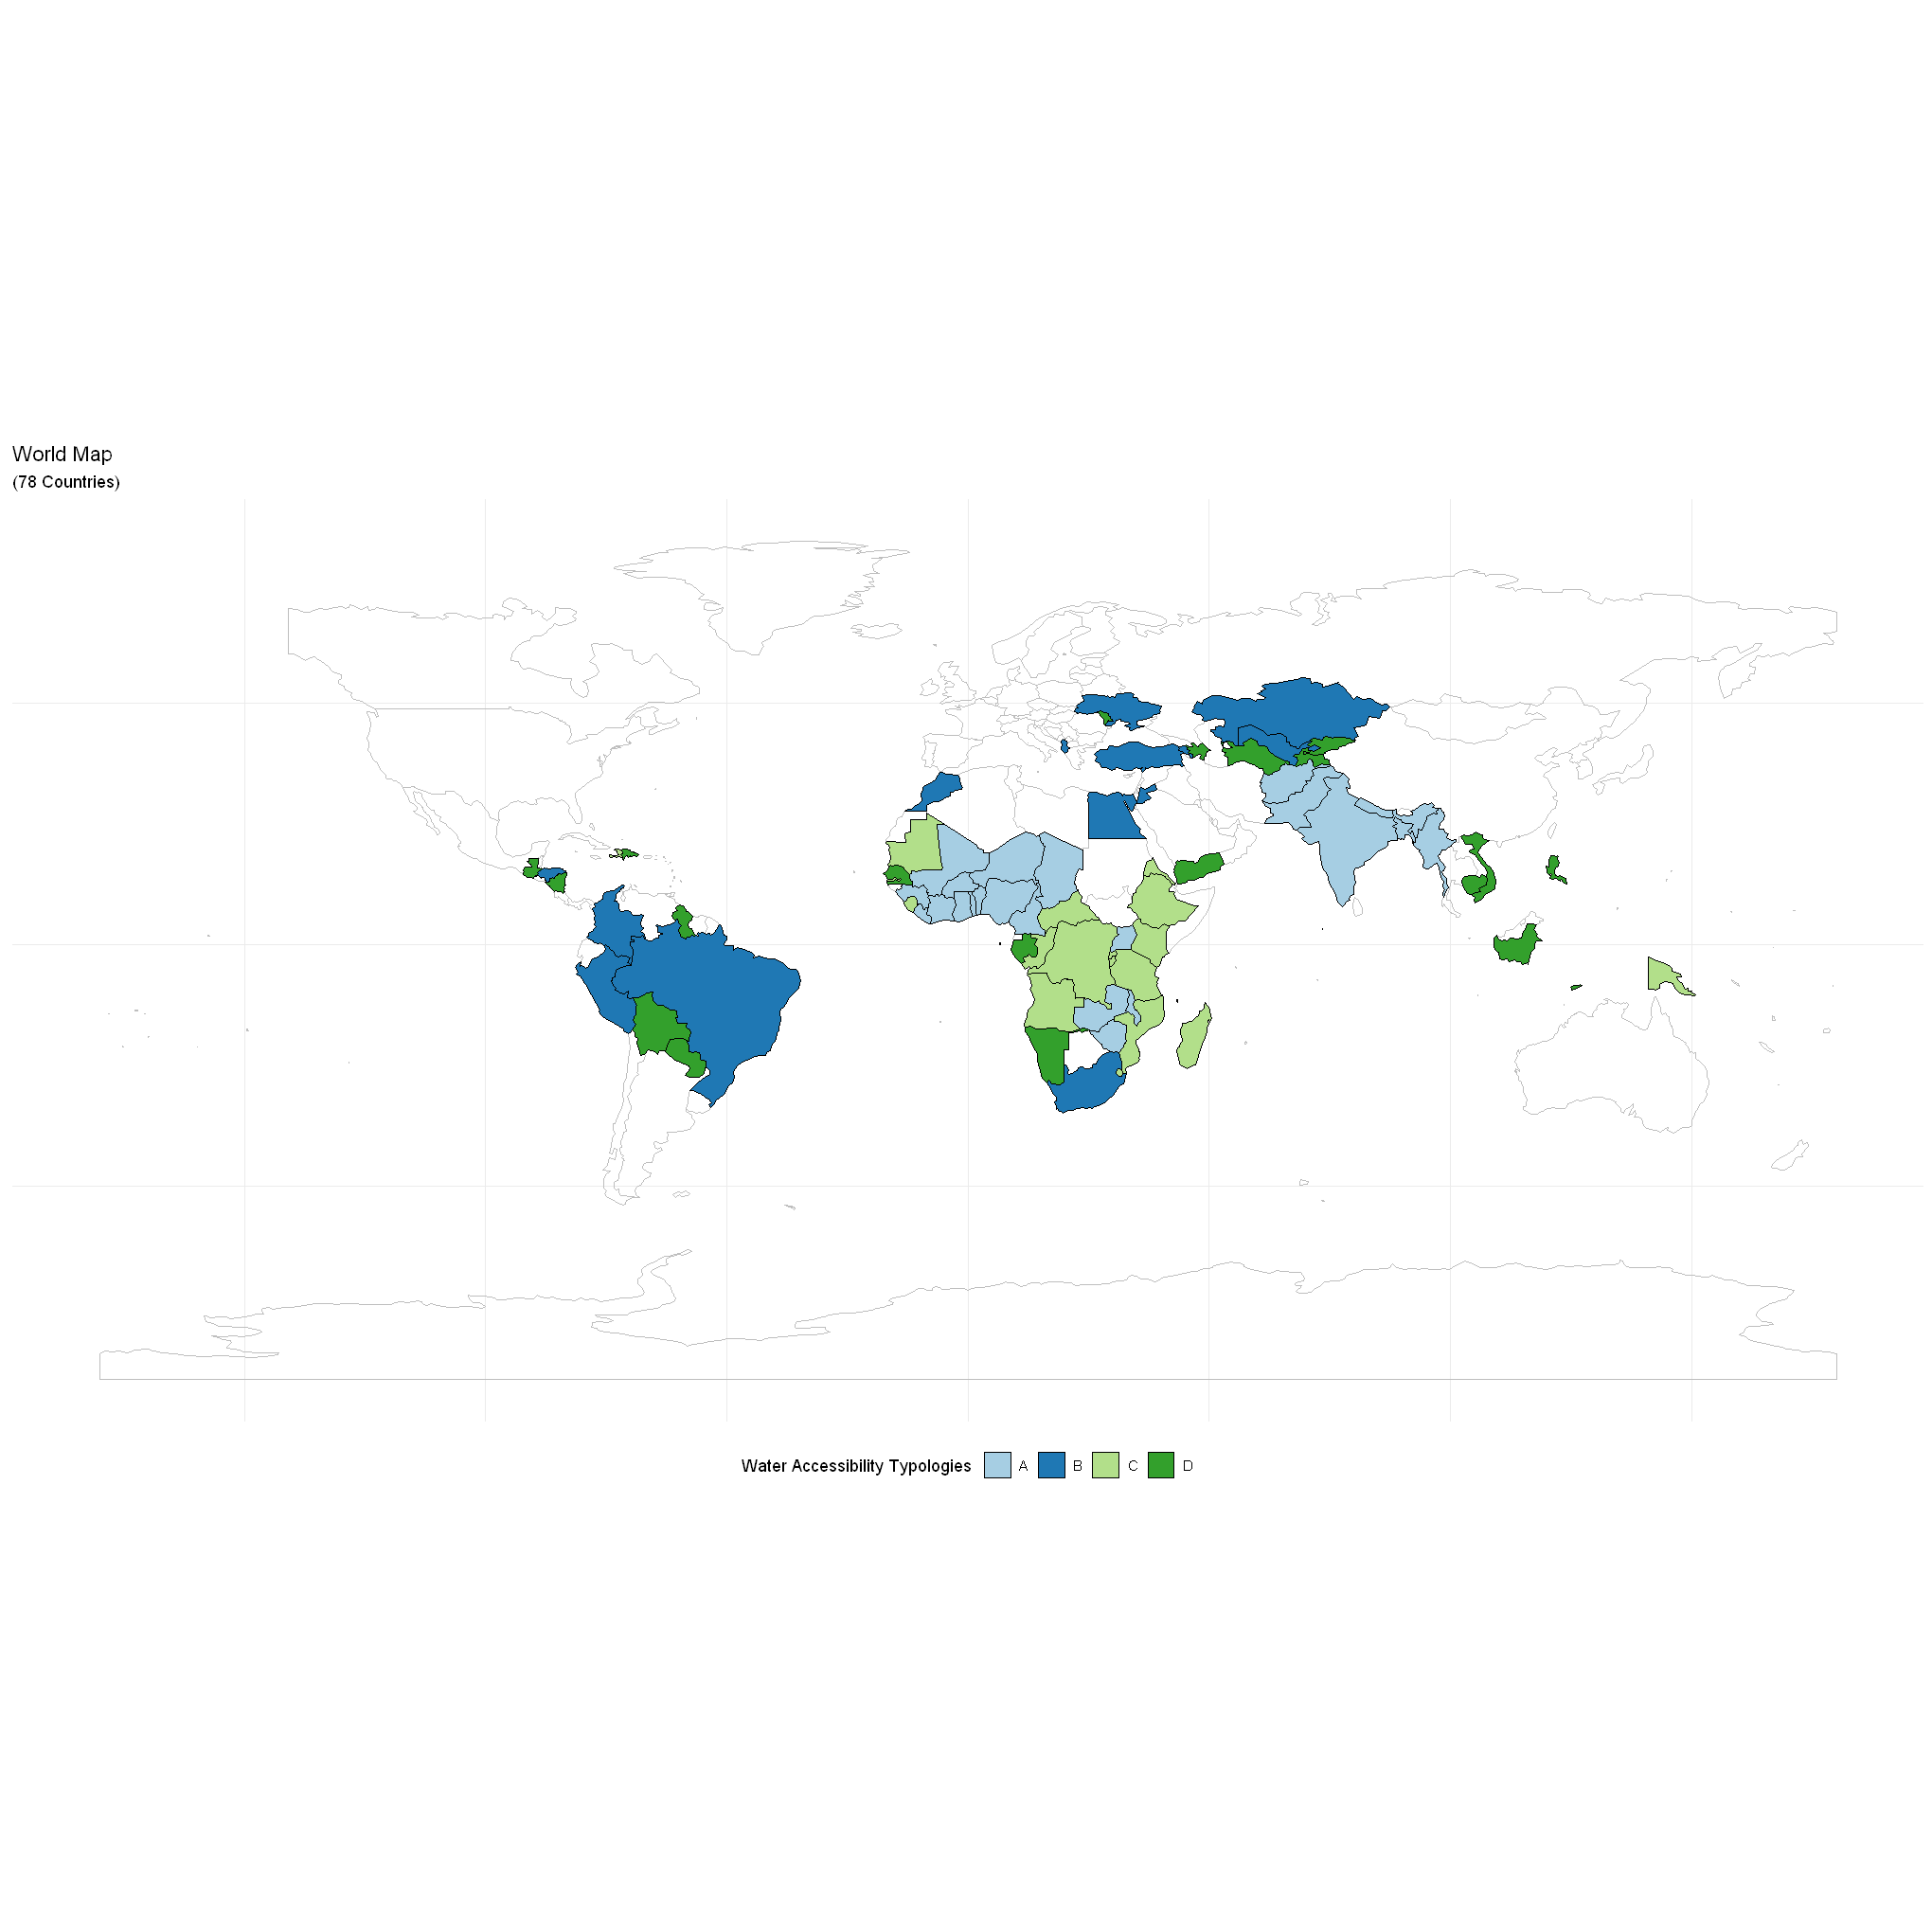

In [245]:
# Plot
options(repr.plot.width=17, repr.plot.height=17)
par(mar = c(1,1,1,1))
par(cex=1)
ggplot() +
    geom_sf(color = "black", fill= 'antiquewhite') +
    xlab("Longitude") + ylab("Latitude") +
    geom_polygon(data= allCoords, mapping = aes(x =long, y=lat,group = region),color="grey",fill=NA) + 
    geom_polygon( data = waterCoords, mapping = aes(x =long, y=lat,group = region, fill=value), size=.3,color="black") +
    expand_limits(x = waterCoords$long, y = waterCoords$lat)  + 
    scale_fill_brewer(palette='Paired', name="Water Accessibility Typologies", na.value="grey", labels = c("A", "B", "C", "D")) +  #labels = c())+
    ggtitle("World Map", subtitle = paste0("(", length(unique(df$region)), " Countries)")) +
    theme_minimal() +
    theme(legend.position = "bottom",
        axis.ticks = element_blank(), 
        axis.title = element_blank(), 
        axis.text =  element_blank()) 
#     #guides(fill = guide_colorbar(barwidth = 10, barheight = .5))


#Ref: https://egallic.fr/en/european-map-using-r/